In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time, math
import cmath
from matplotlib.colors import hsv_to_rgb
import matplotlib
import sys
from numba import jit, cuda, prange, guvectorize, complex128
import cv2


In [2]:
@cuda.jit
def get_grid_cuda_old(Z,coef,lenCoef):
    i, j = cuda.grid(2)
    if i >=0 and i < Z.shape[0] and j >=0 and j < Z.shape[1]:     
        for _ in range(500):
            
            fx=0
            for _i in range(lenCoef):
                fx+=coef[_i]*Z[i,j]**(lenCoef-_i-1)

            dfx=0
            for _i in range(lenCoef-1):
                dfx+=coef[_i]*(lenCoef-_i-1)*Z[i,j]**(lenCoef-_i-2)

            
            # fx=Z[i,j]**3+Z[i,j]**2+Z[i,j]+1
            # dfx=3*Z[i,j]**2+2*Z[i,j]+1
            div=fx/dfx
            Z[i,j]=Z[i,j]-div
            if(abs(div)<1e-6):
                break

In [3]:
@cuda.jit
def get_grid_cuda(Z,coefReal,coefImag,lenCoef):
    i, j = cuda.grid(2)
    if i >=0 and i < Z.shape[0] and j >=0 and j < Z.shape[1]:     
        for _ in range(500):
            
            fx=0
            for _i in range(lenCoef):
                fx+=(coefReal[_i]+coefImag[_i]*1j)*Z[i,j]**(lenCoef-_i-1)

            dfx=0
            for _i in range(lenCoef-1):
                dfx+=(coefReal[_i]+coefImag[_i]*1j)*(lenCoef-_i-1)*Z[i,j]**(lenCoef-_i-2)

            
            # fx=Z[i,j]**3+Z[i,j]**2+Z[i,j]+1
            # dfx=3*Z[i,j]**2+2*Z[i,j]+1
            div=fx/dfx
            Z[i,j]=Z[i,j]-div
            if(abs(div)<1e-6):
                break

[0.76787525+0.7360927j  0.14119788+0.57602745j 0.96680492+0.46576427j
 0.85518765+0.62328026j 0.63360272+0.44277179j 0.43378509+0.89346088j
 0.19860974+0.86242284j 0.67410064+0.44250578j 0.45118537+0.2405588j
 0.36787119+0.63173751j 0.05090083+0.34861613j 0.80932952+0.60455251j
 0.91592675+0.12281071j 0.4762292 +0.87142933j 0.57411433+0.38096408j]
[ 1.00000000e+00+0.00000000e+00j -8.31672107e+00-8.24299503e+00j
  3.73245678e-01+6.41929497e+01j  1.53923231e+02-1.55135535e+02j
 -5.16614082e+02-7.51374989e-01j  6.28305273e+02+6.41789050e+02j
  2.83837608e+01-1.18575904e+03j -8.91686218e+02+8.20008942e+02j
  9.62586439e+02+6.25578036e+01j -3.81931526e+02-4.61156530e+02j
 -3.69603071e+01+2.84998902e+02j  8.56250845e+01-6.03356915e+01j
 -2.73853994e+01-6.19469825e+00j  2.51892910e+00+4.58269283e+00j
  2.10013116e-01-5.68440604e-01j -3.10339993e-02+1.12711689e-02j]
Time taken: 8.500753164291382
[0.62609538 0.63192234 0.85071894 0.88299483 0.32384664 0.0313833
 0.300844   0.71737361 0.0407271 

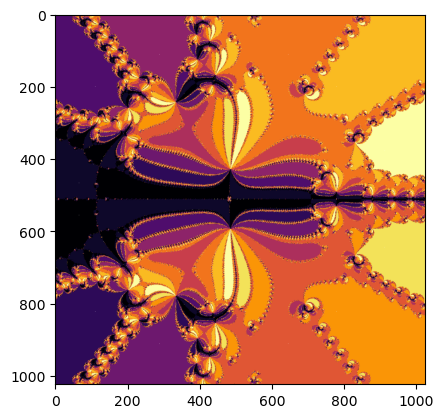

In [7]:
N=2**10
lim=1.15
limj=1.15j
x=np.linspace(-lim,lim,N,dtype=complex)
xj=np.linspace(-limj,limj,N,dtype=complex)
xx,yy=np.meshgrid(x,xj)
X=xx+yy
Z=np.copy(X)

n_roots=15

roots=np.random.random(n_roots) + np.random.random(n_roots) * 1j

print(roots)
coef=np.polynomial.polynomial.polyfromroots(roots)
coef=np.flip(coef)
print(coef)
coef=np.random.rand(n_roots)
cr=np.copy(coef.real)
ci=np.copy(coef.imag)

threadsperblock = (16, 16)
blockspergrid_x = math.ceil(Z.shape[0] / threadsperblock[0])
blockspergrid_y = math.ceil(Z.shape[1] / threadsperblock[1])
blockspergrid = (blockspergrid_x, blockspergrid_y)

start = time.time()
get_grid_cuda[blockspergrid, threadsperblock](Z,cr,ci,len(coef))
print("Time taken:",time.time() - start)


roundOff=1
minima=np.unique(Z.round(roundOff))
print(coef)
print(minima)
print(len(minima))

Img=np.zeros((Z.shape[0],Z.shape[1],3)).astype(np.uint8)
# cmap = matplotlib.cm.get_cmap('viridis')
cmap = matplotlib.cm.get_cmap('inferno')

for i in  range(len(minima)):
    # indx=np.argwhere(Val.round(3)==minima[i])
    indx=np.argwhere(np.flip(Z,0).round(roundOff)==minima[i])
    rgba = cmap(i/(len(minima)-1))
    Img[indx[:,0],indx[:,1],:]=np.array(rgba[:-1])*255
    # print(minima[i].real,minima[i].imag)

for i in  range(len(minima)):   
    print(int((minima[i].real+lim)*N),int((minima[i].imag+abs(limj))*N))
    x,y=int((minima[i].real+lim)/(2*lim)*N),int((minima[i].imag+abs(limj))/(2*abs(limj))*N)    
    Img = cv2.circle(Img, (x,y), radius=0, color=(255, 255, 255), thickness=-1)

Img = cv2.circle(Img, (N//2,N//2), radius=0, color=(255, 255, 255), thickness=-1)

plt.imshow(Img)
# plt.gca().set_aspect('equal')
cv2.imwrite('Fractal.png',cv2.cvtColor(Img, cv2.COLOR_RGB2BGR))
plt.show()
# plt.close()



In [ ]:
N=2**10
lim=1.15
limj=1.15j

x=np.linspace(-lim,lim,N,dtype=complex)
xj=np.linspace(-limj,limj,N,dtype=complex)
xx,yy=np.meshgrid(x,xj)
X=xx+yy

# coef=np.array([1]*15)
coef=np.array(np.random.rand(10))
Z=np.copy(X)
# Z_cpu=np.copy(X)

threadsperblock = (16, 16)
blockspergrid_x = math.ceil(Z.shape[0] / threadsperblock[0])
blockspergrid_y = math.ceil(Z.shape[1] / threadsperblock[1])
blockspergrid = (blockspergrid_x, blockspergrid_y)

start = time.time()
get_grid_cuda[blockspergrid, threadsperblock](Z,coef,len(coef))
print("Time taken:",time.time() - start)

# Z_cpu=get_grid(Z_cpu)

plt.contourf(X.real,X.imag,Z,levels=30)
plt.show()
plt.close()




roundOff=1
minima=np.unique(Z.round(roundOff))
print(coef)
print(minima)
print(len(minima))

Img=np.zeros((Z.shape[0],Z.shape[1],3)).astype(np.uint8)
# cmap = matplotlib.cm.get_cmap('viridis')
cmap = matplotlib.cm.get_cmap('inferno')

for i in  range(len(minima)):
    # indx=np.argwhere(Val.round(3)==minima[i])
    indx=np.argwhere(np.flip(Z,0).round(roundOff)==minima[i])
    rgba = cmap(i/(len(minima)-1))
    Img[indx[:,0],indx[:,1],:]=np.array(rgba[:-1])*255
    # print(minima[i].real,minima[i].imag)

for i in  range(len(minima)):   
    print(int((minima[i].real+lim)*N),int((minima[i].imag+abs(limj))*N))
    x,y=int((minima[i].real+lim)/(2*lim)*N),int((minima[i].imag+abs(limj))/(2*abs(limj))*N)    
    Img = cv2.circle(Img, (x,y), radius=0, color=(255, 255, 255), thickness=-1)

Img = cv2.circle(Img, (N//2,N//2), radius=0, color=(255, 255, 255), thickness=-1)

plt.imshow(Img)
# plt.gca().set_aspect('equal')
cv2.imwrite('Fractal.png',cv2.cvtColor(Img, cv2.COLOR_RGB2BGR))
plt.show()
# plt.close()



# plt.contourf(X.real,X.imag,Z_cpu,levels=30)
# plt.show()
# plt.close()
